# Building an Image Classifier in Five Minutes

A common machine learning task is called **image classification**, where the system tries to recognize and label what it sees.   For example, a self-driving car needs to identify things that it sees in its environment, such as other cars, pedestrians and road signs.

Researchers have created and shared machine learning models that are good at recognizing many different categories of objects in images.  These models can be easily re-purposed to recognize a new set of categories through a process called **transfer learning.**  

In this notebook, we will apply transfer learning to re-purpose a machine learning model called a **neural network** to recognize cats and dogs in images.  To teach the model how to categorize images, we need to provide the model with a collection of labeled example images.  Once the model is "trained" to label these example images correctly, it will be able to accurately label any new, unseen images that you give it.

## Downloading the dataset

Here we download and extract a collection of several hundred images of cats and dogs.  The images are organized into a specific directory structure.  The cat images are under `oxford_pets_cat_dog/train/cat` and the dog images are under `oxford_pets_cat_dog/train/dog`.  


In [1]:
import os
if not os.path.exists('oxford_pets_cat_dog_small.zip'):
  !wget "https://www.dropbox.com/s/pps8tui39ctkha5/oxford_pets_cat_dog_small.zip?dl=1" -O oxford_pets_cat_dog_small.zip
  !unzip -q oxford_pets_cat_dog_small.zip

--2022-06-02 17:27:18--  https://www.dropbox.com/s/pps8tui39ctkha5/oxford_pets_cat_dog_small.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/pps8tui39ctkha5/oxford_pets_cat_dog_small.zip [following]
--2022-06-02 17:27:18--  https://www.dropbox.com/s/dl/pps8tui39ctkha5/oxford_pets_cat_dog_small.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4a7f7f147870d68c6d3c67e327.dl.dropboxusercontent.com/cd/0/get/Bmfr2sGJ4eJS9OmbczenEat8Wf3DOEAt8q-541xW8YrHw3P9On4YOldVpiiYI029ng7NYceAAPPC37-D1CKHMy8KM8_eQlO6g-vP5LjuTQy01eghhQZWd2tOCR-LzRIWOcxmWwq5K87jfdoRwpVAVAxS4iTCkxfdl1jhl9goPmqg6XmotDfOFJkt3VvOHNsLJNE/file?dl=1# [following]
--2022-06-02 17:27:18--  https://uc4a7f7f147870d68c6d3c67e327.dl.dropboxusercontent.com/cd/

We specify the path to the dataset in the variable `DATASET_PATH` here.

In [2]:
#@title Configuration

DATASET_PATH = 'oxford_pets_cat_dog_small' #@param {type: "string"}

This code grabs the names of the class labels from the directory structure.  We will use these class names later when we ask the model to classify images.

In [3]:
import glob
CLASS_LABELS = ','.join(os.path.basename(dir) for dir in sorted(glob.glob(os.path.join(DATASET_PATH,'train','*'))))
print("Class labels:",CLASS_LABELS)

Class labels: cat,dog


## Importing the necessary modules

In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
!pip install wget
import wget
import imageio
import glob

Defaulting to user installation because normal site-packages is not writeable


### Loading the pre-trained neural network

Keras provides many different pre-trained networks.  Here we load a VGG16 network pre-trained on ImageNet.

In [8]:
vgg = tf.keras.applications.VGG16(include_top=True, weights='imagenet',input_shape=(224,224,3))

The model summary displays the sequence of layers in the model.

In [9]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

This model has been trained to predict 1,000 different object categories.  This is why the last layer has 1000 outputs -- one number for each class.  The class with the highest number is the class chosen by the network for the input image.

We want to re-purpose this model to output two classes.  So, we will remove the last layer and replace it with something else.

In [10]:
vgg_features = tf.keras.Model(inputs=vgg.input,outputs=vgg.layers[-2].output)

In [11]:
vgg_features.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Dataset preparation

Now we will load the dataset and set it up as a Tensorflow dataset.

In [12]:
builder = tfds.folder_dataset.ImageFolder(DATASET_PATH)
train_ds = builder.as_dataset(split='train', shuffle_files=False)

2022-06-02 17:28:57.025806: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Here you can see some examples from the dataset with their labels.

2022-06-02 17:29:02.619610: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-02 17:29:02.648658: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3000240000 Hz


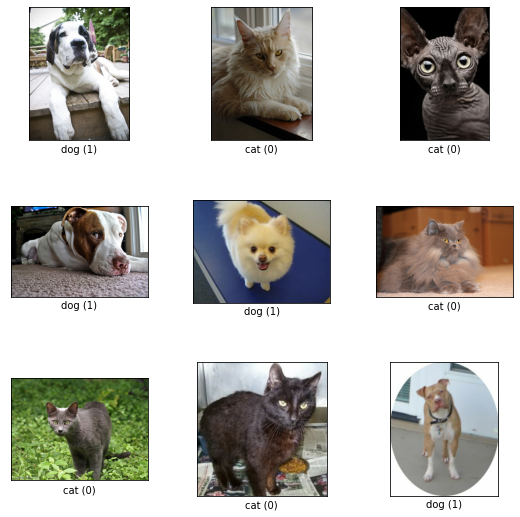

In [13]:
fig = tfds.show_examples(train_ds, builder.info)
fig.show()

We add some processing steps to the dataset:
* Resize images to 224x224
* Preprocess images using the VGG16 preprocess_input() function provided by Keras

In [14]:
train_ds = train_ds.map(lambda x: {'image':tf.image.resize(x['image'],[224,224]),'label':x['label']})
train_ds = train_ds.map(lambda x: {'image':tf.keras.applications.vgg16.preprocess_input(x['image']),'label':x['label']})
train_ds = train_ds.batch(32)
train_ds = train_ds.prefetch(10)

### Extracting deep features

Now we run the images through the VGG network to extract a 4096-dim vector for each image.  

In [15]:
train_features = vgg_features.predict(train_ds.map(lambda x: x['image']),verbose=True)

3/3 [==============================] - 2s 433ms/step


We also put the labels into a Numpy array.

In [16]:
train_labels = np.concatenate([y for y in train_ds.map(lambda x: x['label'])],axis=0)

Now we have a 4096-dimensional feature vector an integer label for each image.

In [17]:
train_features.shape, train_labels.shape

((67, 4096), (67,))

### Transfer learning

Now we can train a classifier called a **support vector machine** on our feature vectors and labels.

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.5, random_state=42)

In [42]:
import sklearn.svm
classifier = sklearn.svm.SVC().fit(X_train,y_train)

Let's evaluate on the training set to see how we did.

**Accuracy** means the percentage of images that the classifier correctly labeled.

In [43]:
from sklearn.metrics import accuracy_score
train_preds = classifier.predict(X_train)
train_acc = accuracy_score(y_train,train_preds)
test_preds = classifier.predict(X_test)
test_acc = accuracy_score(y_test,test_preds)
print(f'Training Accuracy: {train_acc*100}\%')
print(f'Testing Accuracy: {test_acc*100}\%')

Training Accuracy: 100.0\%
Testing Accuracy: 100.0\%


Our model classifies over 99% of the dataset correctly!

**Problem 1:** How many labeled images did we need to get >99% accuracy (approximately)?

In [47]:
print('Total number of images available:',len(train_features))

Total number of images: 67


In [48]:
import pandas as pd
num_training_images = [5,10,15,20,25,30,35,40,45,50]
train_accs = []
test_accs = []
for num_images in num_training_images:
    # Your solution here
results = pd.DataFrame({"num_training_images": num_training_images,"train_acc":train_accs,"test_acc":test_accs})
results

,num_training_images,train_acc,test_acc
0,5,1.0,0.693548
1,10,1.0,0.684211
2,15,1.0,0.673077
3,20,1.0,0.851064
4,25,1.0,0.976190
5,30,1.0,1.000000
6,35,1.0,0.968750
7,40,1.0,1.000000
8,45,1.0,1.000000
9,50,1.0,1.000000


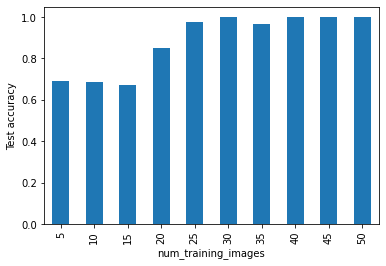

In [53]:
ax = results.set_index('num_training_images')['test_acc'].plot.bar();
ax.set_ylabel('Test accuracy');

The answer for this simulation is between 25 and 30 images. That's pretty impressive I think!

# Testing on new data

Now you can provide a new image to the classifier, and it will say what it thinks is in the image.

Find the URL for an image of a dog and paste it below.

In [54]:
TEST_IMAGE_URL = 'https://i.natgeofe.com/n/46b07b5e-1264-42e1-ae4b-8a021226e2d0/domestic-cat_thumb_square.jpg' #@param {type: 'string'}

In [55]:
filename = wget.download(TEST_IMAGE_URL)

import imageio
image = imageio.imread(filename)
images = image[None,...]

images_resized = tf.image.resize(images,[224,224])
images_pre = tf.keras.applications.vgg16.preprocess_input(images_resized)

features = vgg_features.predict(images_pre)
preds = classifier.predict(features)

class_labels = CLASS_LABELS.split(',')
pred_label = class_labels[preds[0]]

/tmp/ipykernel_1964228/23576459.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


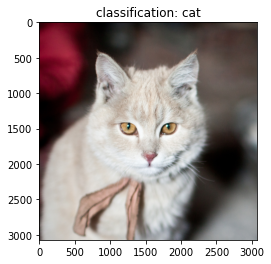

In [56]:
from matplotlib import pyplot as plt
plt.imshow(image)
plt.title(f'classification: {pred_label}')
plt.show()

# Experiment

Now it's your turn!  Make your own dataset and train the image classifier to recognize objects in it.

You should first make a copy of this notebook so that you can save your changes.  Go to File > Save a Copy in Drive.

Then, connect to Google Drive using the button in the "Files" panel on the left.  Pick two categories and assemble a small dataset of images in the proper directory structure in your Google Drive.  For example, you could find ten pictures of apples and ten pictures of oranges using [Google Images](https://images.google.com/), and put them into directories called "fruits/train/apple" and "fruits/train/orange".

Set the `DATASET_PATH` variable to the location of your dataset on Google Drive (e.g. `drive/MyDrive/fruits`) and run through the notebook.  In the last step, provide the URL of a new image that wasn't included in your training set.  Does the model properly recognize the image?

